In [67]:
import torch 
import torch.nn as nn
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

In [68]:
""""
 try to train the model, plot some loss curves for training and testing losses, and report your accuracy! 
 As it's set right now, I think that 100% accuracy should be manageable. 
 Try adding some noise to the time series one you see nice curves. 
 Show the results from all of these experiments and let's see how it goes!
"""

class SimpleSignal(torch.utils.data.Dataset):
    def __init__(self, N=1000, T=100):
        super(SimpleSignal, self).__init__()
        self.N = N
        self.T = T
        self.data, self.labels = self.generate_data()
        self.train_ix, self.test_ix = self.get_ix_splits()
    
    def __getitem__(self, ix):
        return self.data[ix], self.labels[ix]
    
    def __len__(self):
        return len(self.data)

    def get_ix_splits(self):
        split_props = [0.8, 0.1, 0.1] # Train/validation/test split proportions
        indices = range(len(self.data))
        split_points = [int(len(self.data)*i) for i in split_props]
        train_ix = np.random.choice(indices,
                                    split_points[0],
                                    replace=False)
        test_ix = np.random.choice((list(set(indices)-set(train_ix))),
                                    split_points[1],
                                    replace=False)
        return train_ix, test_ix

    def generate_data(self):
        N_pos = int(self.N/2)
        N_neg = int(self.N/2)
        data = [] 
        labels = [] 
        for i in range(N_pos + N_neg):
            time_series = np.zeros(self.T)
            #time_series = np.random.normal(0, .7, self.T) 
# You can make the task harder if you raise the standard deviation of the noise
            if i < N_pos:
                labels.append(0)
            else:
                time_series[np.random.choice(self.T)] = 1 # Put the signal at a random place
                labels.append(1)
            data.append(time_series)
            
        # --- shuffle the data ---
        permutation = np.random.choice(len(data), len(data), replace=False).astype(int)
        data = [data[i] for i in permutation]
        labels = [labels[i] for i in permutation]
        return torch.tensor(data, dtype=torch.float).unsqueeze(2), torch.tensor(labels, dtype=torch.long)

In [69]:
HIDDEN_DIMENSION = 20
N_LAYERS = 1
BATCH_SIZE = 10
N_EPOCHS = 20
LEARNING_RATE = [.1, .005, .00001]
SEQ_LENGTH = 10     #of data
N_INSTANCES = 1000  #of data
N_FEATURES = 1      #dimensions of each input?
N_CLASSES = 2       #dimensions of each output?

# --- create the dataset ---
data = SimpleSignal(T=SEQ_LENGTH, N=N_INSTANCES)
#for i in range(data.N):
    #print(data.data[i], data.labels[i])

In [70]:
# --- define the data loaders ---
train_sampler = SubsetRandomSampler(data.train_ix) # Random sampler for training indices
test_sampler = SubsetRandomSampler(data.test_ix) # Random sampler for testing indices

train_loader = torch.utils.data.DataLoader(dataset=data,
                                           batch_size=BATCH_SIZE, 
                                           sampler=train_sampler,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=data,
                                          batch_size=BATCH_SIZE, 
                                          sampler=test_sampler,
                                          shuffle=False)

# --- define your model here ---
class RNN(nn.Module):
    def __init__(self, HIDDEN_DIMENSION, N_CLASSES, N_FEATURES, N_LAYERS, BATCH_SIZE):
        super(RNN, self).__init__()
        self.N_LAYERS = N_LAYERS
        self.BATCH_SIZE = BATCH_SIZE
        self.HIDDEN_DIMENSION = HIDDEN_DIMENSION
        self.N_CLASSES = N_CLASSES
        
        # --- define mappings here ---
        self.lstm = torch.nn.LSTM(N_FEATURES, HIDDEN_DIMENSION)       #sets up initial weight matrices
        self.out = torch.nn.Linear(HIDDEN_DIMENSION, N_CLASSES)
        #nonlinear part - tells probabilites
        self.softmax = torch.nn.Softmax(dim=1)
    
    def forward(self, X):  #X is input data - tensor shape = (batch size, input dimension)
        # --- define forward pass here ---
        #initialize hidden state - need to do this because this is an RNN/LSTM (you use torch.nn.LSTM above)
        state = (torch.zeros(N_LAYERS, BATCH_SIZE, HIDDEN_DIMENSION), # h_0 initial hidden state
                 torch.zeros(N_LAYERS, BATCH_SIZE, HIDDEN_DIMENSION)) # c_0 initial cell state
        X = torch.transpose(X, 0, 1)  #should have shape timesteps, batch_size, num features
        
        hidden, state = self.lstm(X, state)   #X is timeseries, shape is (timesteps, batch size)
        #hidden = h_t = hidden cell sate after w1 weight matrix (self.LSTM has been applied to the current cell) = this is actually vector containing all h_t's for each cell
        #state = (h_n, c_n) = h_n is hidden state that depends on all previous cells, c_n is cell state that depends on all previous cells
        output = self.out(hidden[-1])   #cell's hidden state gets passed thru w2 (out) weight matrix to produce output
        prediction = self.softmax(output)
        return prediction

In [71]:
loss_dif_lr = []
accuracy_dif_lr = []
loss_testing_dif_lr=[]
accuracy_testing_dif_lr=[]

for i_lr in range(len(LEARNING_RATE)):
    # --- initialize the model and the optimizer ---
    model = RNN(HIDDEN_DIMENSION, N_CLASSES, N_FEATURES, N_LAYERS, BATCH_SIZE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE[i_lr]) 
    # Using the Adam optimizer - don't worry about the details, it's going to update the network's weights.
    criterion = torch.nn.CrossEntropyLoss()   #definig loss function

    # --- training the model ---
    loss_vector_training=[]
    accuracy_vector_training=[]
    for epoch in range(N_EPOCHS):
        loss_sum = 0
        predictions_sum = 0
        labels_sum = 0
        for i, (time_series, labels) in enumerate(train_loader): # Iterate through the training batches
            # --- Forward pass ---
            predictions = model(time_series)   #time_series has to have shape (batch size=10, input dimension=1)
        
            # --- Compute gradients and update weights ---
            optimizer.zero_grad()   #zero gradients, can also do model.zero_grad() in this case
        
            for i in range(10):
                predict = predictions[i,1]
                if predict <=.5:
                    estimate=0
                else:
                    estimate=1
                if estimate==labels[i]:
                    predictions_sum += 1
                labels_sum += 1
            loss = criterion(predictions, labels)    #predictions shape is (10, 2), labels shape is (10)
            loss.backward(retain_graph = True)
            optimizer.step()  #updates parameters using Adam alg rather than grad descent
            loss_sum += loss.item()
            #if (i+1) % 1 == 0:
            #    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, N_EPOCHS, i+1, len(train_loader), loss.item()))
        accuracy = predictions_sum/labels_sum
        loss_total = loss_sum/80
        accuracy_vector_training.append(accuracy)
        loss_vector_training.append(loss_total)
        print('accuracy: ', accuracy)
        print ('Loss for each Epoch:','Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, N_EPOCHS, loss_total))
        
        #----testing----
        loss_vector_testing=[]
        accuracy_vector_testing=[]
        for i, (time_series, labels) in enumerate(test_loader): # Iterate through the testing set, 10 timeseries in 10 batches (100 timeseries total)
                predictions_sum = 0
                labels_sum = 0
                loss_sum = 0
                predictions = model(time_series)   #time_series has to have shape (batch size=10, input dimension=1)

                for i in range(10):
                    predict = predictions[i,1]
                    if predict <=.5:
                        estimate=0
                    else:
                        estimate=1
                    if estimate==labels[i]:
                        predictions_sum += 1
                    labels_sum += 1
                loss = criterion(predictions, labels)    #predictions shape is (10, 2), labels shape is (10)
                loss_sum += loss.item()
                accuracy = predictions_sum/labels_sum
                loss_vector_testing.append(loss_sum)
                accuracy_vector_testing.append(accuracy)
    
    #----keeping track of all losses and accuracies for each learning rate
    loss_dif_lr.append(loss_vector_training)
    accuracy_dif_lr.append(accuracy_vector_training)
    loss_testing_dif_lr.append(loss_vector_testing)
    accuracy_testing_dif_lr.append(accuracy_vector_testing)

accuracy:  0.83
Loss for each Epoch: Epoch [1/20], Loss: 0.4668
accuracy:  1.0
Loss for each Epoch: Epoch [2/20], Loss: 0.3133
accuracy:  1.0
Loss for each Epoch: Epoch [3/20], Loss: 0.3133
accuracy:  1.0
Loss for each Epoch: Epoch [4/20], Loss: 0.3133
accuracy:  1.0
Loss for each Epoch: Epoch [5/20], Loss: 0.3133
accuracy:  1.0
Loss for each Epoch: Epoch [6/20], Loss: 0.3133
accuracy:  1.0
Loss for each Epoch: Epoch [7/20], Loss: 0.3133
accuracy:  1.0
Loss for each Epoch: Epoch [8/20], Loss: 0.3133
accuracy:  1.0
Loss for each Epoch: Epoch [9/20], Loss: 0.3133
accuracy:  1.0
Loss for each Epoch: Epoch [10/20], Loss: 0.3133
accuracy:  1.0
Loss for each Epoch: Epoch [11/20], Loss: 0.3133
accuracy:  1.0
Loss for each Epoch: Epoch [12/20], Loss: 0.3133
accuracy:  1.0
Loss for each Epoch: Epoch [13/20], Loss: 0.3133
accuracy:  1.0
Loss for each Epoch: Epoch [14/20], Loss: 0.3133
accuracy:  1.0
Loss for each Epoch: Epoch [15/20], Loss: 0.3133
accuracy:  1.0
Loss for each Epoch: Epoch [16/20

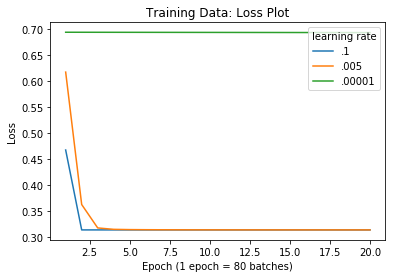

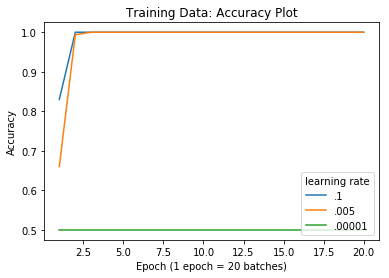

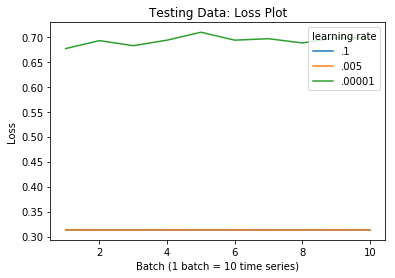

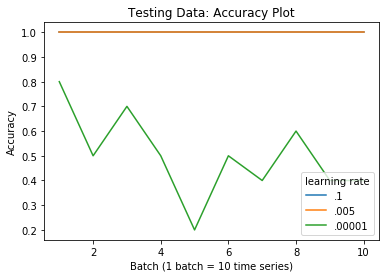

In [73]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

epochs_vector = [i for i in range(1, 21)]
plt.plot(epochs_vector, loss_dif_lr[0])
plt.plot(epochs_vector, loss_dif_lr[1])
plt.plot(epochs_vector, loss_dif_lr[2])
plt.legend(['.1', '.005', '.00001'], loc='upper right', title="learning rate")
plt.title('Training Data: Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch (1 epoch = 80 batches)')
plt.show()

plt.plot(epochs_vector, accuracy_dif_lr[0])
plt.plot(epochs_vector, accuracy_dif_lr[1])
plt.plot(epochs_vector, accuracy_dif_lr[2])
plt.legend(['.1', '.005', '.00001'], loc='lower right', title="learning rate")
plt.title('Training Data: Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch (1 epoch = 20 batches)')
plt.show()

batch_vector = [i for i in range(1, 11)]
plt.plot(batch_vector, loss_testing_dif_lr[0])
plt.plot(batch_vector, loss_testing_dif_lr[1])
plt.plot(batch_vector, loss_testing_dif_lr[2])
plt.legend(['.1', '.005', '.00001'], loc='upper right', title="learning rate")
plt.title('Testing Data: Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Batch (1 batch = 10 time series)')
#plt.axis([0, 10, .5, .8])
plt.show()

plt.plot(batch_vector, accuracy_testing_dif_lr[0])
plt.plot(batch_vector, accuracy_testing_dif_lr[1])
plt.plot(batch_vector, accuracy_testing_dif_lr[2])
plt.legend(['.1', '.005', '.00001'], loc='lower right', title="learning rate")
plt.title('Testing Data: Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Batch (1 batch = 10 time series)')
#plt.axis([0, 10, 0, 1])
plt.show()

In [81]:
def truncate(n, decimals):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

print('Testing Data: Average Accuracy')
print('lr = .1         ', truncate(np.average(accuracy_testing_dif_lr[0]), 2) )
print('lr = .005       ', truncate(np.average(accuracy_testing_dif_lr[1]), 2) )
print('lr = .00001     ', truncate(np.average(accuracy_testing_dif_lr[2]), 2) )

Testing Data: Average Accuracy
lr = .1          1.0
lr = .005        1.0
lr = .00001      0.5
